In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import ekarus.e2e.utils.deformable_mirror_utilities as dmutils

from ekarus.e2e.alpao_deformable_mirror import ALPAODM

basepath = '/home/matte/git/ekarus'

In [ ]:
# Option A: define a DM from the number of actuators
Npix = 128
DM468 = ALPAODM(468,Npix=Npix, basepath=basepath) # defined from configuration, simulating the IFFs with tps module
DM241 = ALPAODM(241,Npix=Npix, basepath=basepath)

# This may take a little while, especially for > 200 acts

[[ 5.  6.  7.  8.  9. 10. 11.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.
   2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.  1.  2.  3.  4.  5.
   6.  7.  8.  9. 10. 11. 12. 13. 14. 15.  1.  2.  3.  4.  5.  6.  7.  8.
   9. 10. 11. 12. 13. 14. 15.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.
  11. 12. 13. 14. 15. 16.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.
  12. 13. 14. 15. 16.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.
  13. 14. 15. 16.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.
  14. 15. 16.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.
  15. 16.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.
  16.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
   1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.  1.  2.  3.
   4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.  2.  3.  4.  5.  6.  7.
   8.  9. 10. 11. 12. 13. 14.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.
   5.  6.  7.  8.  9. 10. 11.]
 [ 0.  

np.float64(0.05258431662526026)

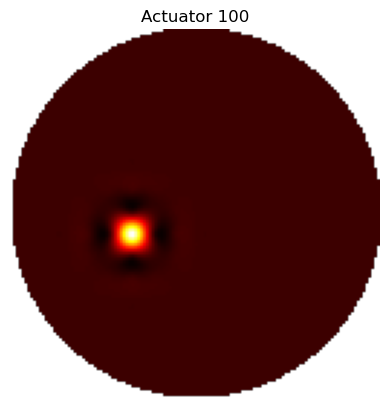

In [5]:
act_id = 100
DM241.plot_surface(surf2plot=DM241.IFF[:,act_id],title = f'Actuator {act_id}')


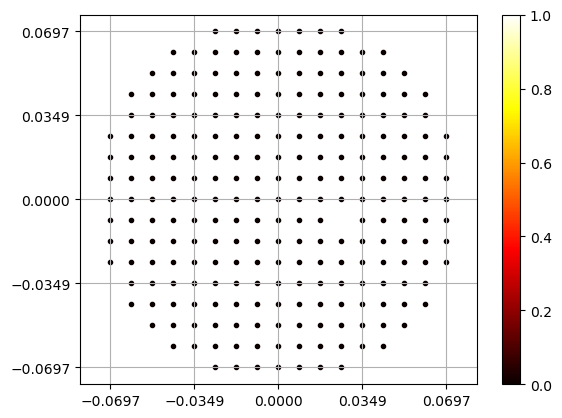

In [5]:
pos_cmd = np.zeros(DM241.Nacts)
pos_cmd[106] = 1
DM241.set_position(pos_cmd, absolute=True)
DM241.plot_position()

np.float64(0.03743869176974266)

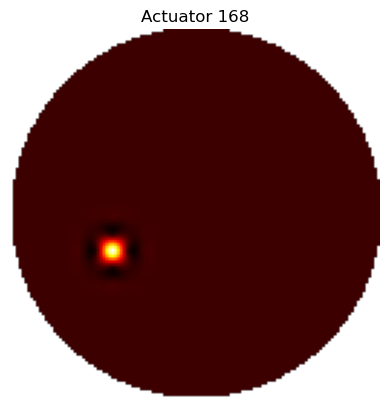

In [4]:
act_id = 168
DM468.plot_surface(surf2plot=DM468.IFF[:,act_id],title = f'Actuator {act_id}')

In [5]:
# Option B: define a DM from real data

# IMPORTANT: make sure you have downloaded the correct data
# from the wiki and uploaded it into ekarus/ekarus/e2e/alpao_dms/
# you can download the data from the wiki:
# http://aowiki.arcetri.inaf.it/pub/ADOPT/AlpaoDm820/20250217_160029.zip?_t=1749657304

tn = '20250217_160029' # Make sure you have downloaded
DM820 = ALPAODM(tn, basepath=basepath) # defined from data measurements

(130, 130, 820)


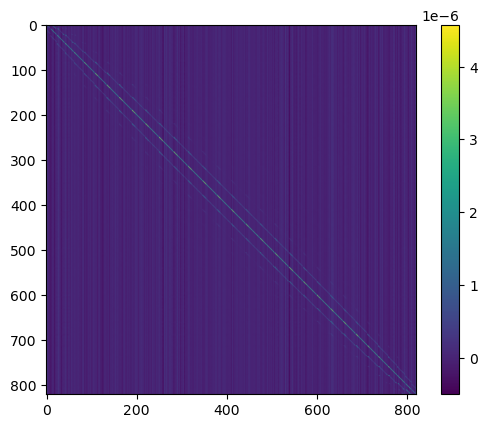

In [6]:
plt.figure()
plt.imshow(DM820.K)
plt.colorbar()

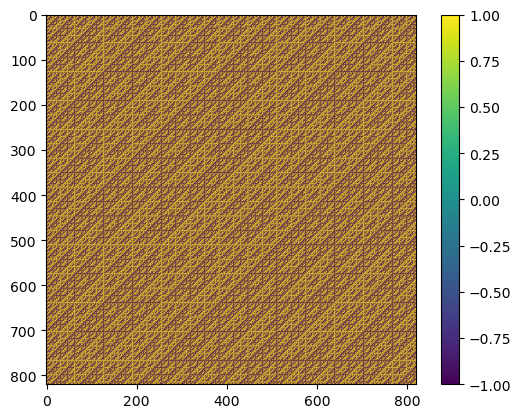

In [7]:
plt.figure()
plt.imshow(DM820.CMat)
plt.colorbar()

np.float64(1.0412570153671917e-07)

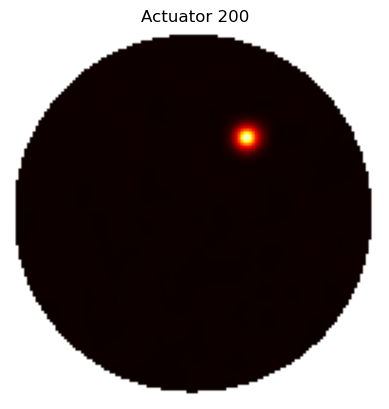

In [8]:
# Show IFFs
act_id = 200
DM820.plot_surface(surf2plot=DM820.IFF[:,act_id],title = f'Actuator {act_id}')

np.float64(0.03743883989395621)

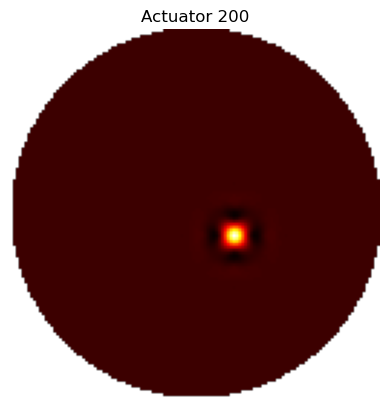

In [9]:
# Show IFFs
act_id = 200
DM468.plot_surface(surf2plot=DM468.IFF[:,act_id],title = f'Actuator {act_id}')

In [10]:
CmdMat = DM820.CMat
CmdMat.shape

(820, 820)

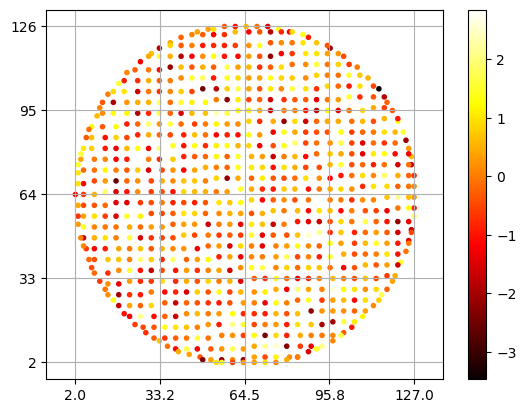

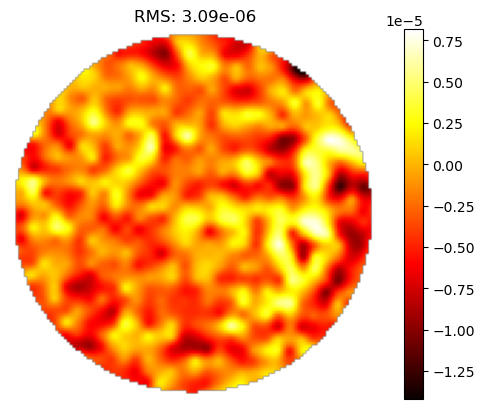

In [11]:
# Apply a random command
new_cmd = np.random.randn(DM820.Nacts)
DM820.set_position(new_cmd)
plt.figure(), DM820.plot_position()
plt.figure(), DM820.plot_surface()
plt.colorbar()

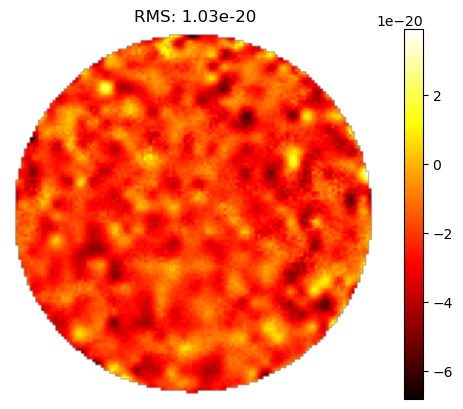

In [12]:
# Apply flat
start_surface = DM820.surface
flat_cmd = DM820.R @ start_surface
DM820.set_position(-flat_cmd)

DM820.plot_surface()
plt.colorbar()

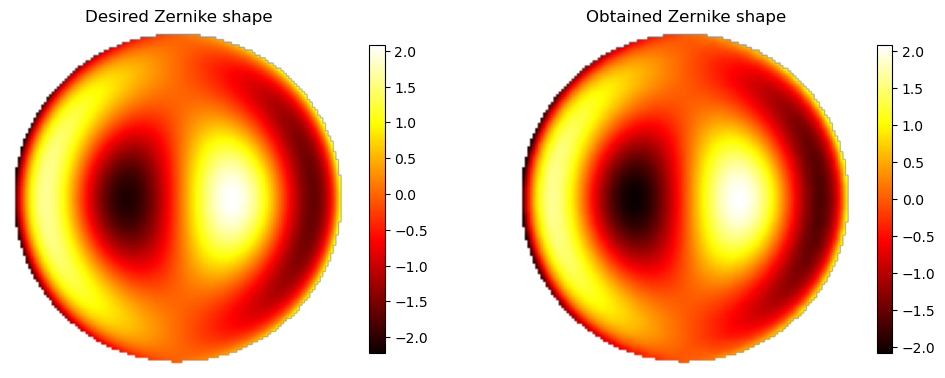

In [13]:
# Apply a Zernike mode
from arte.types.mask import CircularMask
from ekarus.e2e.utils.zernike_coefficients import create_field_from_zernike_coefficients

mask = CircularMask(np.shape(DM820.mask), maskRadius=np.min(np.shape(DM820.mask))//2)

noll = 16
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

zern = np.angle(input_field)

intersection_mask = np.logical_or(mask.mask(), DM820.mask)
zern_shape = zern.data[~intersection_mask]

zern_cmd = DM820.R @ zern_shape
DM820.set_position(zern_cmd, absolute = True)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
DM820.plot_surface(surf2plot = zern_shape, plt_mask = mask.mask(), title='Desired Zernike shape')
plt.colorbar(shrink=0.5)

plt.subplot(1,2,2)
DM820.plot_surface(title='Obtained Zernike shape')
plt.colorbar(shrink=0.5)

In [14]:

def get_circular_mask_from_dm_mask(dm, oversampling:int):

    nx=np.max(dm.mask.shape)
    padded_mask = np.pad(dm.mask, pad_width=(oversampling-1)*nx//2, constant_values=1)

    nx,ny=padded_mask.shape
    x = np.arange(nx)
    y = np.arange(ny)
    X, Y = np.meshgrid(x, y)

    Npix = np.sum(1-dm.mask)
    cx = int(np.round(np.sum(X[~padded_mask])/Npix))
    cy = int(np.round(np.sum(Y[~padded_mask])/Npix))

    R = np.sqrt((X-cx)**2+(Y-cy)**2)
    radius = np.max(R[~padded_mask])

    mask = CircularMask(padded_mask.shape, maskRadius=radius, maskCenter = (cx,cy))
    mask._mask = padded_mask

    return mask

mask820 = get_circular_mask_from_dm_mask(DM820, oversampling=4)
mask468 = get_circular_mask_from_dm_mask(DM468, oversampling=4)

# plt.figure()
# plt.imshow(mask.mask())

# plt.figure()
# plt.imshow(padded_mask)

# plt.figure()
# plt.imshow(np.logical_xor(padded_mask,mask.mask()))

In [15]:
# from arte.utils.zernike_generator import ZernikeGenerator

# zern_modes = 5
# zern_mask = mask820
# zg = ZernikeGenerator(zern_mask)

# for z in range(2, zern_modes + 2):
#     zern = zg.getZernike(z)

#     plt.figure()
#     plt.imshow(np.ma.masked_array(zern,zern_mask.mask()))

In [16]:
# test KL modes generator
from ekarus.analytical.kl_modes import make_modal_base_from_ifs_fft

r0 = 5e-2
L0 = 8
diameter = 32e-3

kl_basis, m2c, singular_values = make_modal_base_from_ifs_fft(1-DM468.mask, Npix, diameter, DM468.IFF.T, r0, L0, zern_modes=0, oversampling=4, verbose = True)

Starting modal basis generation...
Input shapes: pupil_mask=(128, 128), influence_functions=(468, 12849)
Step 1: Removing modes from influence functions...
Step 2: Calculating geometric covariance matrix...
Step 3: SVD decomposition of covariance matrix...
-- IF covariance matrix SVD ---
    initial condition number is: 5.5223774909973145
Step 4: Calculating turbulence covariance matrix...
Computing turbulence covariance matrix...
Step 5: Calculating modal basis...
Final shapes: kl_basis=(467, 12849), m2c=(468, 467)


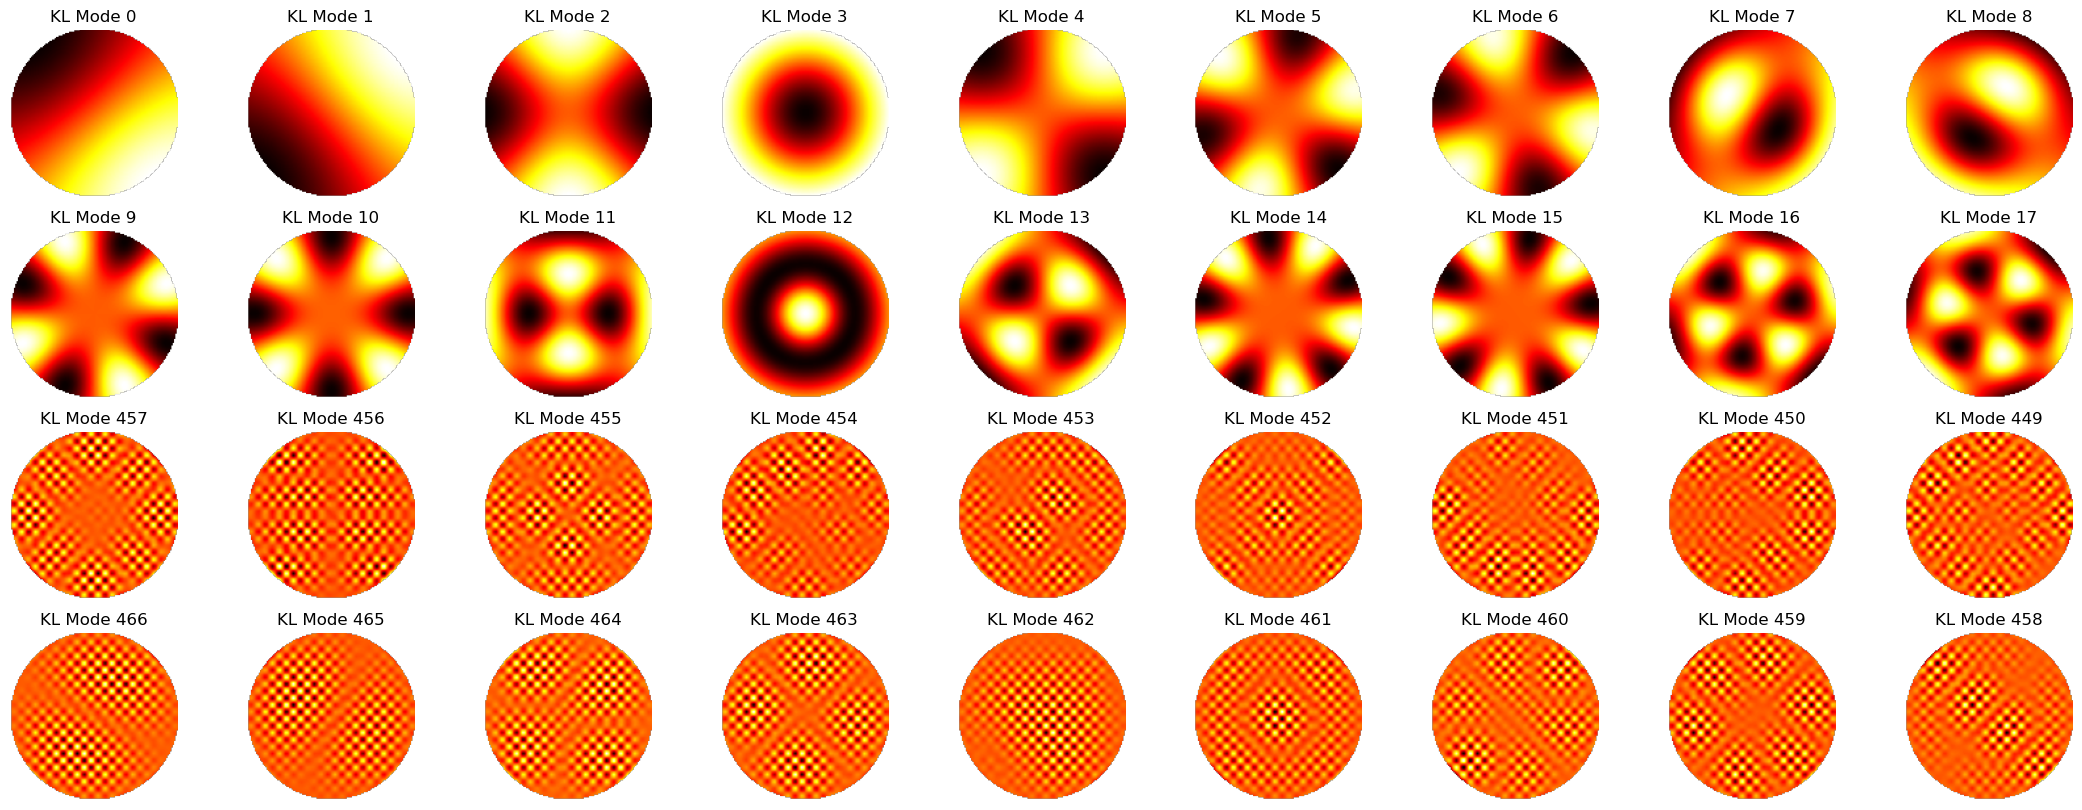

In [17]:

N=9
plt.figure(figsize=(3*N,10))

for i in range(N):
    plt.subplot(4,N,i+1)
    DM468.plot_surface(kl_basis[i,:],title=f'KL Mode {i}')
    plt.subplot(4,N,i+1+N)
    DM468.plot_surface(kl_basis[i+N,:],title=f'KL Mode {i+N}')
    plt.subplot(4,N,i+1+N*2)
    DM468.plot_surface(kl_basis[-i-1-N,:],title=f'KL Mode {np.shape(kl_basis)[0]-i-1-N}')
    plt.subplot(4,N,i+1+N*3)
    DM468.plot_surface(kl_basis[-i-1,:],title=f'KL Mode {np.shape(kl_basis)[0]-i-1}')